In [1]:
# ======================================
# Snippet 1: Data Loading + MFCC Features + Basic Missing Data Analysis
# ======================================

# -----------------------------
# IMPORTS
# -----------------------------
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


print("🚀 Loading competition data... / Competition data load kar rahe hain...")

# -----------------------------
# DATA LOADING
# -----------------------------
train_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/train.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

train_df = pd.read_csv(train_csv)
print(f"✅ Training data loaded: {train_df.shape} / Training data ka size")

# -----------------------------
# TABULAR FEATURES
# -----------------------------
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough',
                'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']

# -----------------------------
# AUDIO FILE MAPPING
# -----------------------------
file_map = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map[folder] = os.path.join(fpath, wavs[0])

print(f"✅ Audio files mapped: {len(file_map)} / Total audio files mapped")

# -----------------------------
# MFCC FEATURE EXTRACTION FUNCTION
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    """Extract MFCC + chroma + mel features / MFCC aur extra features extract karte hain"""
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)

        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)

        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc + 12 + 128)  # Fallback

print("🎵 Extracting MFCC features for all audio files...")

X_audio = []
valid_ids = []
for i, cid in enumerate(train_df['candidateID']):
    if cid in file_map:
        features = extract_mfcc_features(file_map[cid])
        X_audio.append(features)
        valid_ids.append(cid)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} files... / {i+1} files process ho chuki hain")

X_audio = np.array(X_audio)

# -----------------------------
# FILTER TABULAR & TARGET DATA
# -----------------------------
df = train_df[train_df['candidateID'].isin(valid_ids)]
X_tab = df[tab_features].values
y = df['disease'].values

print(f"✅ MFCC features shape: {X_audio.shape}")
print(f"✅ Dataset size after filtering: {len(df)}")
print(f"✅ Unique classes: {len(np.unique(y))}")

# -----------------------------
# BASIC MISSING DATA ANALYSIS
# -----------------------------
missing_data = df[tab_features].isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Feature': tab_features,
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent
})
print("\n🔍 Basic Missing Data Analysis / Missing data summary")
print(missing_summary)

🚀 Loading competition data... / Competition data load kar rahe hain...
✅ Training data loaded: (546, 11) / Training data ka size
✅ Audio files mapped: 882 / Total audio files mapped
🎵 Extracting MFCC features for all audio files...
Processed 100 files... / 100 files process ho chuki hain
Processed 200 files... / 200 files process ho chuki hain
Processed 300 files... / 300 files process ho chuki hain
Processed 400 files... / 400 files process ho chuki hain


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processed 500 files... / 500 files process ho chuki hain
✅ MFCC features shape: (546, 180)
✅ Dataset size after filtering: 546
✅ Unique classes: 3

🔍 Basic Missing Data Analysis / Missing data summary
                                 Feature  Missing_Count  Missing_Percent
age                                  age              0         0.000000
gender                            gender              0         0.000000
tbContactHistory        tbContactHistory              0         0.000000
wheezingHistory          wheezingHistory              0         0.000000
phlegmCough                  phlegmCough              0         0.000000
familyAsthmaHistory  familyAsthmaHistory              0         0.000000
feverHistory                feverHistory              0         0.000000
coldPresent                  coldPresent            148        27.106227
packYears                      packYears              0         0.000000


In [2]:
# ======================================
# Snippet 2: Advanced Imputation (Iterative) + Tabular Preprocessing + Scaling
# ======================================

print("🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Original tabular data
X_tab_original = X_tab.copy()
y_original = y.copy()

# -----------------------------
# 1️⃣ Iterative Imputation (MICE) for all missing values
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)

X_tab_iterative = iterative_imputer.fit_transform(X_tab_original)
print("✅ Iterative imputation applied / Iterative imputation complete")

# -----------------------------
# 2️⃣ Select Iterative Imputation as final dataset
# -----------------------------
X_tab_best = X_tab_iterative
print("✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya")

# -----------------------------
# 3️⃣ Scale Tabular Features
# -----------------------------
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_best)
print("✅ Tabular features scaled / Tabular features scaling complete")


🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...
✅ Iterative imputation applied / Iterative imputation complete
✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya
✅ Tabular features scaled / Tabular features scaling complete


In [3]:
# ======================================
# Snippet 3: Train-Validation Split + MFCC reshaping + Class Weights
# ======================================

print("🚀 Creating train-validation split / Train-validation split bana rahe hain...")

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Filter to cases with available audio data
valid_indices = [i for i, cid in enumerate(train_df["candidateID"]) if cid in file_map]

X_tab_final_scaled = X_tab_scaled[valid_indices]  # Tabular features
X_audio_final = X_audio[valid_indices]           # MFCC / Audio features
y_final = y_original[valid_indices]              # Target labels

print(f"✅ Final dataset: {len(X_tab_final_scaled)} samples / Final dataset samples count")

# -----------------------------
# 1️⃣ Train-Validation Split
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_final_scaled, X_audio_final, y_final,
    test_size=0.15,
    stratify=y_final,
    random_state=42
)

print("✅ Train-validation split done / Train-validation split complete")

# -----------------------------
# 2️⃣ Reshape Audio for CNN Input
# -----------------------------
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)

print(f"Audio train shape: {X_audio_train.shape} / Audio validation shape: {X_audio_val.shape}")

# -----------------------------
# 3️⃣ Compute Class Weights for Imbalanced Data
# -----------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights computed / Class weights: {class_weight_dict}")


🚀 Creating train-validation split / Train-validation split bana rahe hain...
✅ Final dataset: 546 samples / Final dataset samples count
✅ Train-validation split done / Train-validation split complete
Audio train shape: (464, 180, 1) / Audio validation shape: (82, 180, 1)
✅ Class weights computed / Class weights: {0: 1.2997198879551821, 1: 0.7656765676567657, 2: 1.0815850815850816}


In [4]:
# --- Create flattened MFCC for augmentation ---
X_mel_2d = X_audio_train.reshape(X_audio_train.shape[0], -1)
X_tab_mel = X_tab_train
y_mel = y_train

# Advanced augmentation for 1D flattened MFCC/Mel
def advanced_flat_augmentation(feature_vector):
    augmented = feature_vector.copy()
    
    # Random noise
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise
    
    # Random shift
    if np.random.random() > 0.5:
        shift = np.random.randint(-5, 5)
        augmented = np.roll(augmented, shift)
    
    return augmented

# Augmented dataset
X_mel_augmented = []
X_tab_augmented = []
y_augmented = []

# Original data
X_mel_augmented.extend(X_mel_2d)
X_tab_augmented.extend(X_tab_mel)
y_augmented.extend(y_mel)

# Augmented data (3x)
for i in range(len(X_mel_2d)):
    for _ in range(3):
        aug_mel = advanced_flat_augmentation(X_mel_2d[i])
        X_mel_augmented.append(aug_mel)
        X_tab_augmented.append(X_tab_mel[i])
        y_augmented.append(y_mel[i])

X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

print(f"✅ Augmented dataset: {len(X_mel_augmented)} samples (original: {len(X_mel_2d)})")


✅ Augmented dataset: 1856 samples (original: 464)


In [5]:
# ======================================
# 3️⃣4.5️⃣ SPLIT AUGMENTED DATA
# ======================================

print("📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...")

from sklearn.model_selection import train_test_split

X_tab_aug_train, X_tab_aug_val, X_mel_aug_train, X_mel_aug_val, y_aug_train, y_aug_val = train_test_split(
    X_tab_augmented, X_mel_augmented, y_augmented,
    test_size=0.15, stratify=y_augmented, random_state=42
)

print(f"✅ Train set: {len(X_tab_aug_train)} samples, Validation set: {len(X_tab_aug_val)} samples")


📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...
✅ Train set: 1577 samples, Validation set: 279 samples


In [6]:
# ======================================
# 3️⃣5️⃣ FIXED SUPER ADVANCED MODEL
# ======================================

import tensorflow as tf
from tensorflow.keras import layers, Model

print("🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...")
num_classes = 3

def create_fixed_super_advanced_model(tabular_dim, pretrained_dim, num_classes):
    """Fixed super advanced model for 90%+ accuracy"""
    
    # Pre-trained features input
    pretrained_input = tf.keras.Input(shape=(pretrained_dim,), name='pretrained_features')
    
    x_pretrained = layers.Dense(1024, activation='relu')(pretrained_input)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.4)(x_pretrained)
    
    x_pretrained = layers.Dense(512, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.3)(x_pretrained)
    
    x_pretrained = layers.Dense(256, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.2)(x_pretrained)
    
    # Tabular input
    tabular_input = tf.keras.Input(shape=(tabular_dim,), name='tabular_input')
    
    x_tab = layers.Dense(256, activation='relu')(tabular_input)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3)(x_tab)
    
    x_tab = layers.Dense(128, activation='relu')(x_tab)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.2)(x_tab)
    
    x_tab = layers.Dense(64, activation='relu')(x_tab)
    
    # Combine
    combined = layers.concatenate([x_pretrained, x_tab])
    
    # Advanced classification
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Residual block 1
    residual1 = layers.Dense(512, activation='relu')(x)
    residual1 = layers.BatchNormalization()(residual1)
    x = layers.add([x, residual1])
    x = layers.Dropout(0.4)(x)
    
    # Residual block 2
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    residual2 = layers.Dense(256, activation='relu')(x)
    residual2 = layers.BatchNormalization()(residual2)
    x = layers.add([x, residual2])
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[tabular_input, pretrained_input],
        outputs=output,
        name='fixed_super_advanced_model'
    )
    
    return model

# ✅ Create model
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=X_mel_aug_train.shape[1],  # MFCC / flattened features
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Fixed super advanced model created!")
super_model.summary()


2025-12-01 21:23:41.482545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764624221.652418      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764624221.705281      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...


I0000 00:00:1764624236.265340      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Fixed super advanced model created!


Model: "fixed_super_advanced_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pretrained_features │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │    185,344 │ pretrained_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │      2,560 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    164,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_6[0][0]   

 Total params: 1,566,019 (5.97 MB)

 Trainable params: 1,558,339 (5.94 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [7]:
# ======================================
# 3️⃣6️⃣ FIXED SUPER ADVANCED MODEL TRAINING WITH PCA REDUCED MFCC
# ======================================

print("🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...")

from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# --- 1. Flatten MFCC / Mel-spectrograms ---
X_mel_aug_train_flat = X_mel_aug_train.reshape(X_mel_aug_train.shape[0], -1)
X_mel_aug_val_flat   = X_mel_aug_val.reshape(X_mel_aug_val.shape[0], -1)

# --- 2. Reduce dimensionality to 128 features using PCA ---
pca = PCA(n_components=128, random_state=42)
X_mel_aug_train_pca = pca.fit_transform(X_mel_aug_train_flat)
X_mel_aug_val_pca   = pca.transform(X_mel_aug_val_flat)

print(f"✅ MFCC features reduced: Train {X_mel_aug_train_pca.shape}, Val {X_mel_aug_val_pca.shape}")

# --- 3. Create super advanced model ---
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=128,  # Matches PCA output
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Super advanced model created and compiled!")

# --- 4. Class weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug_train), y=y_aug_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weight_dict}")

# --- 5. Callbacks ---
enhanced_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=20,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'fixed_super_advanced_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# --- 6. Train the model ---
print("🚀 Training fixed super advanced model with PCA-reduced MFCC...")
super_history = super_model.fit(
    [X_tab_aug_train, X_mel_aug_train_pca],
    y_aug_train,
    batch_size=16,
    epochs=300,
    validation_data=([X_tab_aug_val, X_mel_aug_val_pca], y_aug_val),
    callbacks=enhanced_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("✅ Fixed super advanced training completed!")

# --- 7. Load best weights and evaluate ---
super_model.load_weights('fixed_super_advanced_model.h5')

super_pred = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
super_accuracy = accuracy_score(y_aug_val, np.argmax(super_pred, axis=1))

print(f"\n🎯 FIXED SUPER ADVANCED MODEL ACCURACY: {super_accuracy:.4f}")

# --- 8. Performance check ---
previous_best = 0.8780
improvement = super_accuracy - previous_best

if super_accuracy >= 0.90:
    print(f"🎉 🎉 🎉 UNBELIEVABLE! 90%+ ACHIEVED! 🎉 🎉 🎉")
    print(f"🚀 BREAKTHROUGH! +{improvement:.4f} improvement!")
elif super_accuracy >= 0.88:
    print(f"🔥 EXCELLENT! {super_accuracy:.4f} accuracy!")
    print(f"💪 Very close to 90%!")
else:
    print(f"💪 Good progress: {super_accuracy:.4f}")


🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...
✅ MFCC features reduced: Train (1577, 128), Val (279, 128)
✅ Super advanced model created and compiled!
✅ Class weights: {0: 1.301155115511551, 1: 0.7651625424551188, 2: 1.0816186556927299}
🚀 Training fixed super advanced model with PCA-reduced MFCC...
Epoch 1/300


I0000 00:00:1764624245.014861     115 service.cc:148] XLA service 0x794188002fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764624245.015399     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764624246.042718     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


38/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3196 - loss: 1.4260

I0000 00:00:1764624252.065757     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3194 - loss: 1.4057
Epoch 1: val_accuracy improved from -inf to 0.29032, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.3196 - loss: 1.4052 - val_accuracy: 0.2903 - val_loss: 1.1483 - learning_rate: 1.0000e-04
Epoch 2/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3428 - loss: 1.3185
Epoch 2: val_accuracy improved from 0.29032 to 0.31541, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3429 - loss: 1.3186 - val_accuracy: 0.3154 - val_loss: 1.1377 - learning_rate: 1.0000e-04
Epoch 3/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3978 - loss: 1.2293
Epoch 3: val_accuracy did not improve from 0.31541
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3969 - loss: 1.2302 - val_accuracy: 0.3154 - val_loss: 1.1284 - learning_rate: 1.0000e-04
Epoch 4/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3814 - loss: 1.2177
Epoch 4: val_accuracy improved from 0.31541 to 0.34409, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3814 - loss: 1.2178 - val_accuracy: 0.3441 - val_loss: 1.1141 - learning_rate: 1.0000e-04
Epoch 5/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3901 - loss: 1.1984
Epoch 5: val_accuracy improved from 0.34409 to 0.43011, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3903 - loss: 1.1982 - val_accuracy: 0.4301 - val_loss: 1.0725 - learning_rate: 1.0000e-04
Epoch 6/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4174 - loss: 1.1835
Epoch 6: val_accuracy improved from 0.43011 to 0.43728, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4184 - loss: 1.1817 - val_accuracy: 0.4373 - val_loss: 1.0399 - learning_rate: 1.0000e-04
Epoch 7/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4384 - loss: 1.1428
Epoch 7: val_accuracy improved from 0.43728 to 0.49104, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4387 - loss: 1.1417 - val_accuracy: 0.4910 - val_loss: 0.9967 - learning_rate: 1.0000e-04
Epoch 8/300
93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4528 - loss: 1.0825
Epoch 8: val_accuracy improved from 0.49104 to 0.60932, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4534 - loss: 1.0828 - val_accuracy: 0.6093 - val_loss: 0.9300 - learning_rate: 1.0000e-04
Epoch 9/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4892 - loss: 1.0220
Epoch 9: val_accuracy improved from 0.60932 to 0.64516, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4890 - loss: 1.0224 - val_accuracy: 0.6452 - val_loss: 0.8700 - learning_rate: 1.0000e-04
Epoch 10/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5035 - loss: 0.9911
Epoch 10: val_accuracy improved from 0.64516 to 0.67384, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5036 - loss: 0.9909 - val_accuracy: 0.6738 - val_loss: 0.8100 - learning_rate: 1.0000e-04
Epoch 11/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5531 - loss: 0.9207
Epoch 11: val_accuracy improved from 0.67384 to 0.68817, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5535 - loss: 0.9209 - val_accuracy: 0.6882 - val_loss: 0.7786 - learning_rate: 1.0000e-04
Epoch 12/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5788 - loss: 0.8912
Epoch 12: val_accuracy improved from 0.68817 to 0.71326, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5795 - loss: 0.8903 - val_accuracy: 0.7133 - val_loss: 0.7284 - learning_rate: 1.0000e-04
Epoch 13/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6215 - loss: 0.8279
Epoch 13: val_accuracy improved from 0.71326 to 0.74910, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6208 - loss: 0.8311 - val_accuracy: 0.7491 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 14/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6760 - loss: 0.7648
Epoch 14: val_accuracy did not improve from 0.74910
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6759 - loss: 0.7648 - val_accuracy: 0.7419 - val_loss: 0.6696 - learning_rate: 1.0000e-04
Epoch 15/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6739 - loss: 0.7573
Epoch 15: val_accuracy improved from 0.74910 to 0.75627, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6739 - loss: 0.7572 - val_accuracy: 0.7563 - val_loss: 0.6307 - learning_rate: 1.0000e-04
Epoch 16/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6909 - loss: 0.7471
Epoch 16: val_accuracy improved from 0.75627 to 0.77061, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6912 - loss: 0.7460 - val_accuracy: 0.7706 - val_loss: 0.6238 - learning_rate: 1.0000e-04
Epoch 17/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7169 - loss: 0.6919
Epoch 17: val_accuracy improved from 0.77061 to 0.78495, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7153 - loss: 0.6943 - val_accuracy: 0.7849 - val_loss: 0.6209 - learning_rate: 1.0000e-04
Epoch 18/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.7088
Epoch 18: val_accuracy improved from 0.78495 to 0.78853, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7218 - loss: 0.7075 - val_accuracy: 0.7885 - val_loss: 0.6119 - learning_rate: 1.0000e-04
Epoch 19/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7134 - loss: 0.7044
Epoch 19: val_accuracy improved from 0.78853 to 0.79211, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7135 - loss: 0.7042 - val_accuracy: 0.7921 - val_loss: 0.5964 - learning_rate: 1.0000e-04
Epoch 20/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7246 - loss: 0.6866
Epoch 20: val_accuracy improved from 0.79211 to 0.79928, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7249 - loss: 0.6863 - val_accuracy: 0.7993 - val_loss: 0.5931 - learning_rate: 1.0000e-04
Epoch 21/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7176 - loss: 0.6719
Epoch 21: val_accuracy did not improve from 0.79928
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7178 - loss: 0.6719 - val_accuracy: 0.7957 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 22/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7537 - loss: 0.6219
Epoch 22: val_accuracy did not improve from 0.79928
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7542 - loss: 0.6221 - val_accuracy: 0.7885 - val_loss: 0.6006 - learning_rate: 1.0000e-04
Epoch 23/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7511 - loss: 0.6458
Epoch 23: val_accuracy did not improve from 0.79928
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7508 - loss: 0.6465 - val_accuracy: 0.7778 - val_loss: 0.5891 - learning_rate: 1.0000e-04
Epoch 24/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7562 - loss: 0.6062 - val_accuracy: 0.8029 - val_loss: 0.5565 - learning_rate: 1.0000e-04
Epoch 30/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7779 - loss: 0.5915
Epoch 30: val_accuracy improved from 0.80287 to 0.81720, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7776 - loss: 0.5909 - val_accuracy: 0.8172 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 31/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7713 - loss: 0.6033
Epoch 31: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7714 - loss: 0.6023 - val_accuracy: 0.8029 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 32/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7977 - loss: 0.5580
Epoch 32: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7965 - loss: 0.5620 - val_accuracy: 0.8029 - val_loss: 0.5423 - learning_rate: 1.0000e-04
Epoch 33/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7963 - loss: 0.5640
Epoch 33: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7944 - loss: 0.5658 - val_accuracy: 0.7993 - val_loss: 0.5386 - learning_rate: 1.0000e-04
Epoch 34/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7995 - loss: 0.5212 - val_accuracy: 0.8208 - val_loss: 0.4952 - learning_rate: 1.0000e-04
Epoch 46/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8221 - loss: 0.4576
Epoch 46: val_accuracy improved from 0.82079 to 0.82437, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8204 - loss: 0.4630 - val_accuracy: 0.8244 - val_loss: 0.4906 - learning_rate: 1.0000e-04
Epoch 47/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7979 - loss: 0.5331
Epoch 47: val_accuracy did not improve from 0.82437
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7979 - loss: 0.5331 - val_accuracy: 0.8136 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 48/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8067 - loss: 0.4943
Epoch 48: val_accuracy did not improve from 0.82437
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8062 - loss: 0.4959 - val_accuracy: 0.8244 - val_loss: 0.4781 - learning_rate: 1.0000e-04
Epoch 49/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8148 - loss: 0.5276
Epoch 49: val_accuracy improved from 0.82437 to 0.82796, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8145 - loss: 0.5276 - val_accuracy: 0.8280 - val_loss: 0.4677 - learning_rate: 1.0000e-04
Epoch 50/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8027 - loss: 0.4961
Epoch 50: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8043 - loss: 0.4951 - val_accuracy: 0.8244 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 51/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8178 - loss: 0.4998
Epoch 51: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8178 - loss: 0.4998 - val_accuracy: 0.8244 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 52/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.4612
Epoch 52: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8282 - loss: 0.4620 - val_accuracy: 0.8172 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 53/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8328 - loss: 0.4489 - val_accuracy: 0.8387 - val_loss: 0.4421 - learning_rate: 1.0000e-04
Epoch 70/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8199 - loss: 0.4487
Epoch 70: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8201 - loss: 0.4491 - val_accuracy: 0.8387 - val_loss: 0.4346 - learning_rate: 1.0000e-04
Epoch 71/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8102 - loss: 0.4571
Epoch 71: val_accuracy improved from 0.83871 to 0.84946, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8103 - loss: 0.4570 - val_accuracy: 0.8495 - val_loss: 0.4303 - learning_rate: 1.0000e-04
Epoch 72/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8432 - loss: 0.4245
Epoch 72: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8431 - loss: 0.4246 - val_accuracy: 0.8495 - val_loss: 0.4344 - learning_rate: 1.0000e-04
Epoch 73/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8335 - loss: 0.4393
Epoch 73: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8335 - loss: 0.4395 - val_accuracy: 0.8459 - val_loss: 0.4292 - learning_rate: 1.0000e-04
Epoch 74/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8375 - loss: 0.3947
Epoch 74: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8373 - loss: 0.3951 - val_accuracy: 0.8351 - val_loss: 0.4324 - learning_rate: 1.0000e-04
Epoch 75/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8563 - loss: 0.4011 - val_accuracy: 0.8566 - val_loss: 0.4165 - learning_rate: 1.0000e-04
Epoch 79/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8491 - loss: 0.4129
Epoch 79: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8486 - loss: 0.4131 - val_accuracy: 0.8423 - val_loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 80/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7999 - loss: 0.4753
Epoch 80: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8000 - loss: 0.4750 - val_accuracy: 0.8495 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 81/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8277 - loss: 0.3907
Epoch 81: val_accuracy improved from 0.85663 to 0.86380, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8285 - loss: 0.3909 - val_accuracy: 0.8638 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 82/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8179 - loss: 0.4177
Epoch 82: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8180 - loss: 0.4176 - val_accuracy: 0.8530 - val_loss: 0.4092 - learning_rate: 1.0000e-04
Epoch 83/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8473 - loss: 0.4074
Epoch 83: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8475 - loss: 0.4067 - val_accuracy: 0.8495 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 84/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8432 - loss: 0.4124
Epoch 84: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8433 - loss: 0.4121 - val_accuracy: 0.8638 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 85/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8355 - loss: 0.4262 - val_accuracy: 0.8710 - val_loss: 0.4008 - learning_rate: 1.0000e-04
Epoch 86/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8672 - loss: 0.3624
Epoch 86: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8668 - loss: 0.3631 - val_accuracy: 0.8566 - val_loss: 0.4001 - learning_rate: 1.0000e-04
Epoch 87/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8453 - loss: 0.4216
Epoch 87: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8459 - loss: 0.4178 - val_accuracy: 0.8638 - val_loss: 0.4021 - learning_rate: 1.0000e-04
Epoch 88/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8192 - loss: 0.4223
Epoch 88: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.4205 - val_accuracy: 0.8530 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 89/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8373 - loss: 0.3908 - val_accuracy: 0.8746 - val_loss: 0.3880 - learning_rate: 1.0000e-04
Epoch 98/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8721 - loss: 0.3396
Epoch 98: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8719 - loss: 0.3397 - val_accuracy: 0.8746 - val_loss: 0.3900 - learning_rate: 1.0000e-04
Epoch 99/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8210 - loss: 0.4163
Epoch 99: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8243 - loss: 0.4107 - val_accuracy: 0.8746 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 100/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8740 - loss: 0.3258
Epoch 100: val_accuracy improved from 0.87455 to 0.87814, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8738 - loss: 0.3260 - val_accuracy: 0.8781 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 101/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8329 - loss: 0.4175
Epoch 101: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8332 - loss: 0.4168 - val_accuracy: 0.8674 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 102/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8683 - loss: 0.3312
Epoch 102: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8683 - loss: 0.3312 - val_accuracy: 0.8746 - val_loss: 0.3852 - learning_rate: 1.0000e-04
Epoch 103/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8871 - loss: 0.3021
Epoch 103: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8869 - loss: 0.3024 - val_accuracy: 0.8781 - val_loss: 0.3762 - learning_rate: 1.0000e-04
Epoch 10

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8577 - loss: 0.3706 - val_accuracy: 0.8889 - val_loss: 0.3738 - learning_rate: 1.0000e-04
Epoch 105/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.3424
Epoch 105: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.3424 - val_accuracy: 0.8674 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 106/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.3358
Epoch 106: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8691 - loss: 0.3371 - val_accuracy: 0.8781 - val_loss: 0.3678 - learning_rate: 1.0000e-04
Epoch 107/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8734 - loss: 0.3397
Epoch 107: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8736 - loss: 0.3390 - val_accuracy: 0.8781 - val_loss: 0.3710 - learning_rate: 1.0000e-04
Epoch 10

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8973 - loss: 0.2724 - val_accuracy: 0.8925 - val_loss: 0.3625 - learning_rate: 1.0000e-04
Epoch 119/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8741 - loss: 0.3177
Epoch 119: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8741 - loss: 0.3169 - val_accuracy: 0.8925 - val_loss: 0.3655 - learning_rate: 1.0000e-04
Epoch 120/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8756 - loss: 0.3156
Epoch 120: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8758 - loss: 0.3152 - val_accuracy: 0.8889 - val_loss: 0.3550 - learning_rate: 1.0000e-04
Epoch 121/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8829 - loss: 0.3168
Epoch 121: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8829 - loss: 0.3166 - val_accuracy: 0.8746 - val_loss: 0.3725 - learning_rate: 1.0000e-04
Epoch 12

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8923 - loss: 0.2557 - val_accuracy: 0.8996 - val_loss: 0.3647 - learning_rate: 1.0000e-04
Epoch 132/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8911 - loss: 0.2776
Epoch 132: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8909 - loss: 0.2776 - val_accuracy: 0.8996 - val_loss: 0.3558 - learning_rate: 1.0000e-04
Epoch 133/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8905 - loss: 0.2848
Epoch 133: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8901 - loss: 0.2854 - val_accuracy: 0.8925 - val_loss: 0.3704 - learning_rate: 1.0000e-04
Epoch 134/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8946 - loss: 0.2695
Epoch 134: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8949 - loss: 0.2688 - val_accuracy: 0.8889 - val_loss: 0.3680 - learning_rate: 1.0000e-04
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9085 - loss: 0.2457 - val_accuracy: 0.9032 - val_loss: 0.3546 - learning_rate: 1.0000e-04
Epoch 150/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9182 - loss: 0.2253
Epoch 150: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9164 - loss: 0.2290 - val_accuracy: 0.8853 - val_loss: 0.3750 - learning_rate: 1.0000e-04
Epoch 151/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9109 - loss: 0.2528
Epoch 151: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9111 - loss: 0.2520 - val_accuracy: 0.8996 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 152/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8938 - loss: 0.2474
Epoch 152: val_accuracy improved from 0.90323 to 0.90681, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8939 - loss: 0.2479 - val_accuracy: 0.9068 - val_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 153/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8959 - loss: 0.2482
Epoch 153: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.2476 - val_accuracy: 0.8853 - val_loss: 0.3706 - learning_rate: 1.0000e-04
Epoch 154/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9101 - loss: 0.2288
Epoch 154: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9102 - loss: 0.2285 - val_accuracy: 0.8889 - val_loss: 0.3866 - learning_rate: 1.0000e-04
Epoch 155/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9081 - loss: 0.2247
Epoch 155: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9080 - loss: 0.2250 - val_accuracy: 0.8925 - val_loss: 0.3774 - learning_rate: 1.0000e-04
Epoch 15

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9138 - loss: 0.2117 - val_accuracy: 0.9140 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 166/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9261 - loss: 0.1953
Epoch 166: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9260 - loss: 0.1955 - val_accuracy: 0.9068 - val_loss: 0.3486 - learning_rate: 1.0000e-04
Epoch 167/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9162 - loss: 0.2041
Epoch 167: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9162 - loss: 0.2041 - val_accuracy: 0.9104 - val_loss: 0.3532 - learning_rate: 1.0000e-04
Epoch 168/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9280 - loss: 0.1920
Epoch 168: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9278 - loss: 0.1925 - val_accuracy: 0.8996 - val_loss: 0.3524 - learning_rate: 1.0000e-04
Epoch 16

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9092 - loss: 0.2330 - val_accuracy: 0.9247 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 171/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9096 - loss: 0.2145
Epoch 171: val_accuracy did not improve from 0.92473
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9095 - loss: 0.2146 - val_accuracy: 0.9068 - val_loss: 0.3527 - learning_rate: 1.0000e-04
Epoch 172/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9201 - loss: 0.1948
Epoch 172: val_accuracy did not improve from 0.92473
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9195 - loss: 0.1977 - val_accuracy: 0.9068 - val_loss: 0.3562 - learning_rate: 1.0000e-04
Epoch 173/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9203 - loss: 0.1946
Epoch 173: val_accuracy did not improve from 0.92473
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9200 - loss: 0.1952 - val_accuracy: 0.8925 - val_loss: 0.3765 - learning_rate: 1.0000e-04
Epoch 17

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9239 - loss: 0.1879 - val_accuracy: 0.9283 - val_loss: 0.3723 - learning_rate: 1.0000e-04
Epoch 189/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9363 - loss: 0.1532
Epoch 189: val_accuracy did not improve from 0.92832
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9358 - loss: 0.1541 - val_accuracy: 0.9104 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 190/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9495 - loss: 0.1426
Epoch 190: val_accuracy did not improve from 0.92832
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9490 - loss: 0.1430 - val_accuracy: 0.9211 - val_loss: 0.3928 - learning_rate: 1.0000e-04
Epoch 191/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9289 - loss: 0.1940
Epoch 191: val_accuracy did not improve from 0.92832
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9291 - loss: 0.1935 - val_accuracy: 0.9032 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 19

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9403 - loss: 0.1673 - val_accuracy: 0.9355 - val_loss: 0.3837 - learning_rate: 1.0000e-04
Epoch 197/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9269 - loss: 0.1730
Epoch 197: val_accuracy did not improve from 0.93548
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9268 - loss: 0.1737 - val_accuracy: 0.9283 - val_loss: 0.3680 - learning_rate: 1.0000e-04
Epoch 198/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9343 - loss: 0.1718
Epoch 198: val_accuracy did not improve from 0.93548
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9342 - loss: 0.1722 - val_accuracy: 0.9176 - val_loss: 0.3821 - learning_rate: 1.0000e-04
Epoch 199/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9391 - loss: 0.1692
Epoch 199: val_accuracy did not improve from 0.93548
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9388 - loss: 0.1697 - val_accuracy: 0.9283 - val_loss: 0.3682 - learning_rate: 1.0000e-04
Epoch 20

📊 Evaluating Super Advanced Model...


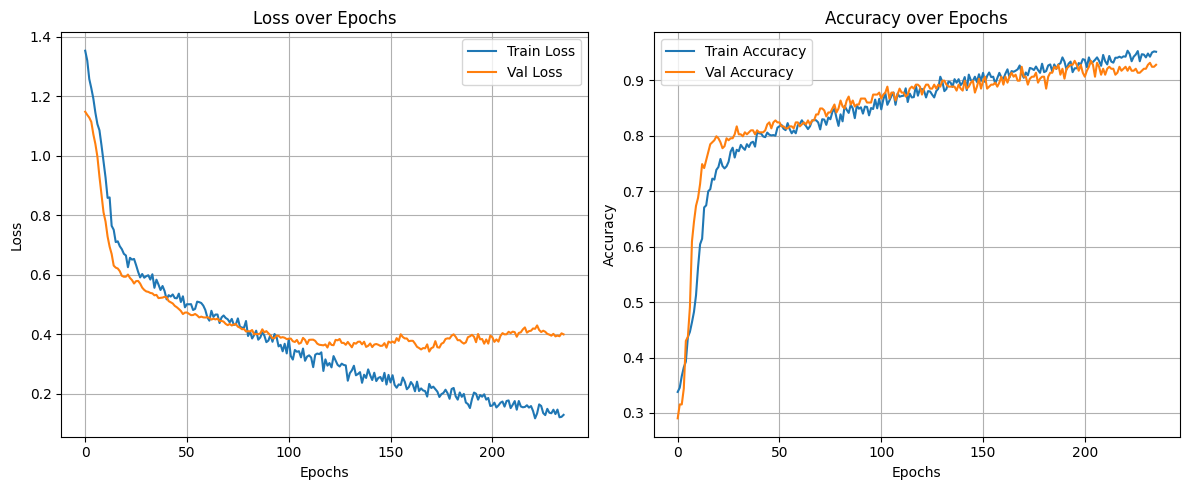

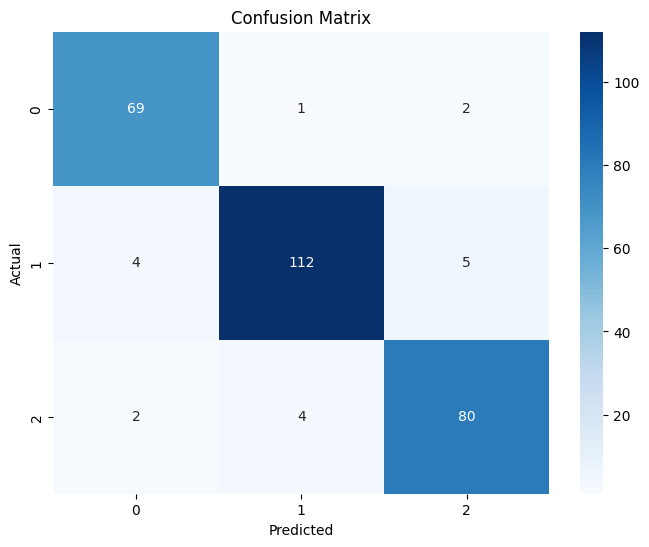

📄 Classification Report:

              precision    recall  f1-score   support

           0     0.9200    0.9583    0.9388        72
           1     0.9573    0.9256    0.9412       121
           2     0.9195    0.9302    0.9249        86

    accuracy                         0.9355       279
   macro avg     0.9323    0.9381    0.9349       279
weighted avg     0.9360    0.9355    0.9355       279


🎯 Overall Validation Accuracy: 0.9355


In [8]:
# ======================================
# 3️⃣7️⃣ MODEL EVALUATION & METRICS
# ======================================


print("📊 Evaluating Super Advanced Model...")

# --- 1. Training history plots ---
history = super_history.history

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Predictions on validation set ---
y_val_pred_probs = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_aug_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 4. Classification Report ---
report = classification_report(y_aug_val, y_val_pred, digits=4)
print("📄 Classification Report:\n")
print(report)

# --- 5. Overall accuracy ---
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_aug_val, y_val_pred)
print(f"\n🎯 Overall Validation Accuracy: {accuracy:.4f}")


In [9]:
"""
COMPLETE TEST PIPELINE FOR RESPIRATORY SOUNDS CLASSIFICATION
This script processes test data exactly like training data and makes predictions.
"""

import os
import librosa
import numpy as np
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

class TestDataProcessor:
    def __init__(self, model_path='fixed_super_advanced_model.h5'):
        """Initialize the test data processor"""
        self.model_path = model_path
        self.tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 
                            'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 
                            'coldPresent', 'packYears']
        self.model = None
        self.pca = None
        self.scaler = None
        self.imputer = None
        
    def load_model_and_preprocessors(self):
        """Load trained model and preprocessing objects"""
        print("📥 Loading model and preprocessing objects...")
        
        # Load model
        self.model = load_model(self.model_path)
        print("✅ Model loaded")
        
        # Note: In production, you should save and load these from training
        # For now, we'll create them with same parameters
        self.pca = PCA(n_components=128, random_state=42)
        self.scaler = StandardScaler()
        self.imputer = IterativeImputer(max_iter=10, random_state=42)
        
        return True
    
    def extract_audio_features(self, audio_path, test_csv_path):
        """Extract MFCC features from test audio files"""
        print("🎵 Processing audio files...")
        
        # Load test data
        test_df = pd.read_csv(test_csv_path)
        
        # Map audio files
        file_map = {}
        for folder in os.listdir(audio_path):
            fpath = os.path.join(audio_path, folder)
            if os.path.isdir(fpath):
                wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
                if wavs:
                    file_map[folder] = os.path.join(fpath, wavs[0])
        
        # Extract features
        X_audio = []
        valid_ids = []
        
        for i, cid in enumerate(test_df['candidateID']):
            if cid in file_map:
                try:
                    features = self._extract_single_audio(file_map[cid])
                    X_audio.append(features)
                    valid_ids.append(cid)
                except Exception as e:
                    print(f"Error processing {cid}: {e}")
                    continue
        
        X_audio = np.array(X_audio)
        test_df_filtered = test_df[test_df['candidateID'].isin(valid_ids)]
        
        print(f"✅ Audio features extracted: {X_audio.shape}")
        print(f"✅ Valid test samples: {len(test_df_filtered)}")
        
        return X_audio, test_df_filtered, valid_ids
    
    def _extract_single_audio(self, file_path, n_mfcc=40, duration=5, sr=22050):
        """Extract features from single audio file"""
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)
        
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)
        
        return np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
    
    def process_tabular_data(self, test_df):
        """Process tabular data (imputation + scaling)"""
        print("📊 Processing tabular data...")
        
        X_tab = test_df[self.tab_features].values
        
        # Impute missing values
        X_tab_imputed = self.imputer.fit_transform(X_tab)
        
        # Scale features
        X_tab_scaled = self.scaler.fit_transform(X_tab_imputed)
        
        print(f"✅ Tabular data processed: {X_tab_scaled.shape}")
        return X_tab_scaled
    
    def reduce_audio_features(self, X_audio):
        """Apply PCA to reduce audio features"""
        print("🔧 Reducing audio features with PCA...")
        
        X_audio_flat = X_audio.reshape(X_audio.shape[0], -1)
        X_audio_pca = self.pca.fit_transform(X_audio_flat)
        
        print(f"✅ Audio features reduced: {X_audio_pca.shape}")
        return X_audio_pca
    
    def make_predictions(self, X_tab, X_audio_pca):
        """Make predictions using the trained model"""
        print("🔮 Making predictions...")
        
        predictions = self.model.predict(
            [X_tab, X_audio_pca],
            batch_size=16,
            verbose=1
        )
        
        predicted_classes = np.argmax(predictions, axis=1)
        
        print(f"✅ Predictions made: {len(predicted_classes)} samples")
        return predictions, predicted_classes
    
    def create_submission(self, candidate_ids, predictions, predicted_classes):
        """Create submission file with predictions"""
        print("💾 Creating submission file...")
        
        # Create results DataFrame
        results_df = pd.DataFrame({
            'candidateID': candidate_ids,
            'predicted_class': predicted_classes,
            'confidence_0': predictions[:, 0],
            'confidence_1': predictions[:, 1],
            'confidence_2': predictions[:, 2],
            'max_confidence': predictions.max(axis=1)
        })
        
        # Save to CSV
        results_df.to_csv('test_predictions_detailed.csv', index=False)
        
        # Create simple submission (just IDs and predictions)
        simple_submission = pd.DataFrame({
            'candidateID': candidate_ids,
            'predicted_disease': predicted_classes
        })
        simple_submission.to_csv('submission.csv', index=False)
        
        print("✅ Submission files created:")
        print("   - test_predictions_detailed.csv (with confidence scores)")
        print("   - submission.csv (simple format)")
        
        return results_df
    
    def run_pipeline(self, audio_path, test_csv_path):
        """Run complete test pipeline"""
        print("=" * 60)
        print("🚀 STARTING TEST DATA PROCESSING PIPELINE")
        print("=" * 60)
        
        # Step 1: Load model
        self.load_model_and_preprocessors()
        
        # Step 2: Extract audio features
        X_audio, test_df_filtered, valid_ids = self.extract_audio_features(
            audio_path, test_csv_path
        )
        
        # Step 3: Process tabular data
        X_tab = self.process_tabular_data(test_df_filtered)
        
        # Step 4: Reduce audio features
        X_audio_pca = self.reduce_audio_features(X_audio)
        
        # Step 5: Make predictions
        predictions, predicted_classes = self.make_predictions(X_tab, X_audio_pca)
        
        # Step 6: Create submission
        results_df = self.create_submission(valid_ids, predictions, predicted_classes)
        
        # Step 7: Print summary
        self.print_summary(predictions, predicted_classes)
        
        print("=" * 60)
        print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        
        return results_df
    
    def print_summary(self, predictions, predicted_classes):
        """Print prediction summary"""
        print("\n📈 PREDICTION SUMMARY:")
        print("-" * 40)
        
        # Class distribution
        unique, counts = np.unique(predicted_classes, return_counts=True)
        for cls, count in zip(unique, counts):
            percentage = (count / len(predicted_classes)) * 100
            print(f"Class {cls}: {count} samples ({percentage:.1f}%)")
        
        # Confidence analysis
        max_confidences = predictions.max(axis=1)
        print(f"\n🎯 Confidence Analysis:")
        print(f"Average confidence: {max_confidences.mean():.3f}")
        print(f"Minimum confidence: {max_confidences.min():.3f}")
        print(f"Maximum confidence: {max_confidences.max():.3f}")
        print(f"Confidence < 0.5: {(max_confidences < 0.5).sum()} samples")
        print(f"Confidence > 0.9: {(max_confidences > 0.9).sum()} samples")

# Main execution
if __name__ == "__main__":
    # Initialize processor
    processor = TestDataProcessor(model_path='fixed_super_advanced_model.h5')
    
    # Define paths
    TEST_CSV_PATH = "/kaggle/input/airs-ai-in-respiratory-sounds/test.csv"
    AUDIO_PATH = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"
    
    # Run pipeline
    results = processor.run_pipeline(AUDIO_PATH, TEST_CSV_PATH)
    
    # Show sample predictions
    print("\n🔍 SAMPLE PREDICTIONS:")
    print(results.head(10))

🚀 STARTING TEST DATA PROCESSING PIPELINE
📥 Loading model and preprocessing objects...


✅ Model loaded
🎵 Processing audio files...
✅ Audio features extracted: (338, 180)
✅ Valid test samples: 338
📊 Processing tabular data...
✅ Tabular data processed: (338, 9)
🔧 Reducing audio features with PCA...
✅ Audio features reduced: (338, 128)
🔮 Making predictions...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
✅ Predictions made: 338 samples
💾 Creating submission file...
✅ Submission files created:
   - test_predictions_detailed.csv (with confidence scores)
   - submission.csv (simple format)

📈 PREDICTION SUMMARY:
----------------------------------------
Class 0: 90 samples (26.6%)
Class 1: 109 samples (32.2%)
Class 2: 139 samples (41.1%)

🎯 Confidence Analysis:
Average confidence: 0.884
Minimum confidence: 0.401
Maximum confidence: 1.000
Confidence < 0.5: 6 samples
Confidence > 0.9: 214 samples
🎉 PIPELINE COMPLETED SUCCESSFULLY!

🔍 SAMPLE PREDICTIONS:
     candidateID  predicted_class  confidence_0  confidence_1  confidence_2  \
0  136bac9a3e081                0      0.929277      0.